## Melakukan koneksi ke copernicus Data Space

In [1]:
!pip install openeo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [openeo]2m5/6 [openeo]]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


Menginstal library openeo yang diperlukan untuk mengakses data satelit dari Copernicus Data Space Ecosystem. OpenEO adalah API standar untuk mengakses data Earth Observation secara cloud-based.

In [ ]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt

Penjelasan:

- openeo: Untuk koneksi ke layanan data satelit

- pandas: Untuk manipulasi dan analisis data

- matplotlib.pyplot: Untuk visualisasi data

### Melakukan koneksi ke copernicus Data Space

In [ ]:
# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Koordinat Daerah Banyuwangi


In [ ]:
# 2. AOI
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [114.35709036207243, -8.197131998083478],
            [114.35709036207243, -8.240574211884947],
            [114.38741190504254, -8.240574211884947],
            [114.38741190504254, -8.197131998083478],
            [114.35709036207243, -8.197131998083478],
        ]
    ],
}

Mendefinisikan Area of Interest (AOI) dalam format GeoJSON polygon yang mencakup wilayah Kabupaten Bangkalan.

In [ ]:
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 114.35709036207243,
        "south": -8.240574211884947,
        "east": 114.38741190504254,
        "north": -8.197131998083478,
    },
    temporal_extent=["2025-01-01", "2025-10-01"],
    bands=["NO2"],
)

Penjelasan:

- Memuat koleksi data Sentinel-5P Level 2

- spatial_extent: Membatasi data sesuai koordinat Bangkalan

- temporal_extent: Periode data dari 1 Januari 2025 - 1 Oktober 2025

- bands: Hanya mengambil band NO₂ (nitrogen dioksida)

### Mengambil Data Nitrogen Dioksida(NO2)

In [ ]:
# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV",)

# 8. Unduh hasil job
results = job.get_results()
results.download_files("no2_results")

0:00:00 Job 'j-25102403465743d382b8c11e455c36b0': send 'start'
0:00:14 Job 'j-25102403465743d382b8c11e455c36b0': queued (progress 0%)
0:00:19 Job 'j-25102403465743d382b8c11e455c36b0': queued (progress 0%)
0:00:26 Job 'j-25102403465743d382b8c11e455c36b0': queued (progress 0%)
0:00:34 Job 'j-25102403465743d382b8c11e455c36b0': queued (progress 0%)
0:00:44 Job 'j-25102403465743d382b8c11e455c36b0': queued (progress 0%)
0:00:56 Job 'j-25102403465743d382b8c11e455c36b0': queued (progress 0%)
0:01:12 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)
0:01:31 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)
0:01:55 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)
0:02:25 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)
0:03:03 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)
0:03:50 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)
0:04:48 Job 'j-25102403465743d382b8c11e455c36b0': running (progress N/A)


[PosixPath('no2_results/timeseries.csv'),
 PosixPath('no2_results/job-results.json')]

Penjelasan:

- Masking: Menghilangkan nilai negatif yang merupakan data invalid

- Agregasi temporal: Menghitung rata-rata harian dari multiple pengukuran per hari

- Agregasi spasial: Menghitung rata-rata spasial dalam AOI Bangkalan

- Batch processing: Menjalankan pemrosesan di server dan mengunduh hasil dalam format CSV

In [ ]:
import os
import shutil

old_name = "no2_results/timeseries.csv"
new_name = "no2_results/no2_banyuwangi_data.csv"

if os.path.exists(old_name):
    shutil.move(old_name, new_name)
    print(f"File renamed from 'timeseries.csv' to 'no2_bangkalan_data.csv'")
else:
    print("File timeseries.csv not found")

File renamed from 'timeseries.csv' to 'no2_bangkalan_data.csv'


 Mengganti nama file default “timeseries.csv” menjadi “no2_banyuwangi_data.csv” untuk penamaan yang lebih deskriptif.

In [ ]:
# 9. Baca file CSV hasil
import os
df =pd.read_csv(os.path.join("no2_results", "no2_banyuwangi_data.csv"))

In [ ]:
# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

df

/tmp/ipython-input-3399061483.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


,date,feature_index,NO2,month
0,2025-02-26 00:00:00+00:00,0,NaN,2025-02
1,2025-03-02 00:00:00+00:00,0,NaN,2025-03
2,2025-03-04 00:00:00+00:00,0,NaN,2025-03
3,2025-02-25 00:00:00+00:00,0,NaN,2025-02
4,2025-03-03 00:00:00+00:00,0,NaN,2025-03
...,...,...,...,...
269,2025-05-15 00:00:00+00:00,0,0.000025,2025-05
270,2025-05-14 00:00:00+00:00,0,NaN,2025-05
271,2025-05-13 00:00:00+00:00,0,NaN,2025-05
272,2025-05-09 00:00:00+00:00,0,NaN,2025-05


In [ ]:
NO2 = pd.read_csv('no2_results/no2_banyuwangi_data.csv')
NO2 = NO2.sort_values(by='date')
NO2.isnull().sum()

,0
date,0
feature_index,0
NO2,161


In [ ]:
missing_count = NO2.isnull().sum()
missing_percent = (missing_count / len(NO2)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.00
feature_index,0,0.00
NO2,161,58.76


/tmp/ipython-input-3930139431.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",


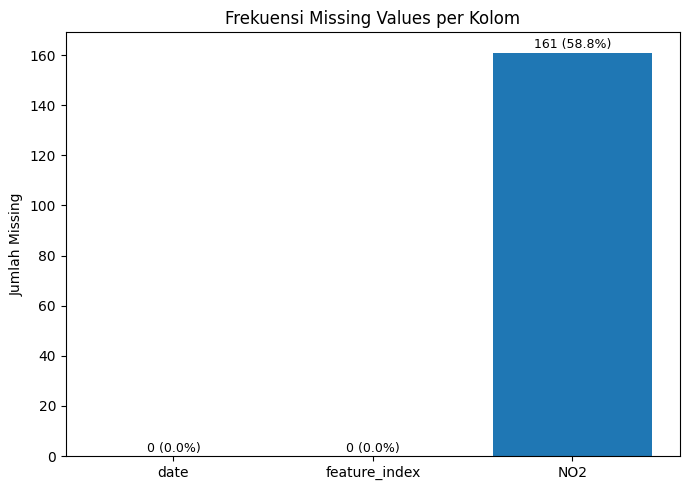

In [ ]:
missing_count = NO2.isnull().sum()
missing_percent = (missing_count / len(NO2)) * 100

fig, ax = plt.subplots(figsize=(7,5))

bars = ax.bar(missing_count.index, missing_count)

ax.set_title("Frekuensi Missing Values per Kolom")
ax.set_ylabel("Jumlah Missing")

for i, v in enumerate(missing_count):
    ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Mengecek Informasi Dataset

In [ ]:
NO2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274 entries, 126 to 24
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           274 non-null    object 
 1   feature_index  274 non-null    int64  
 2   NO2            113 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.6+ KB


### Visualisasi Rata-Rata Kualitas Udara NO2 Setiap Bulan di Banyuwangi

/tmp/ipython-input-4048192070.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


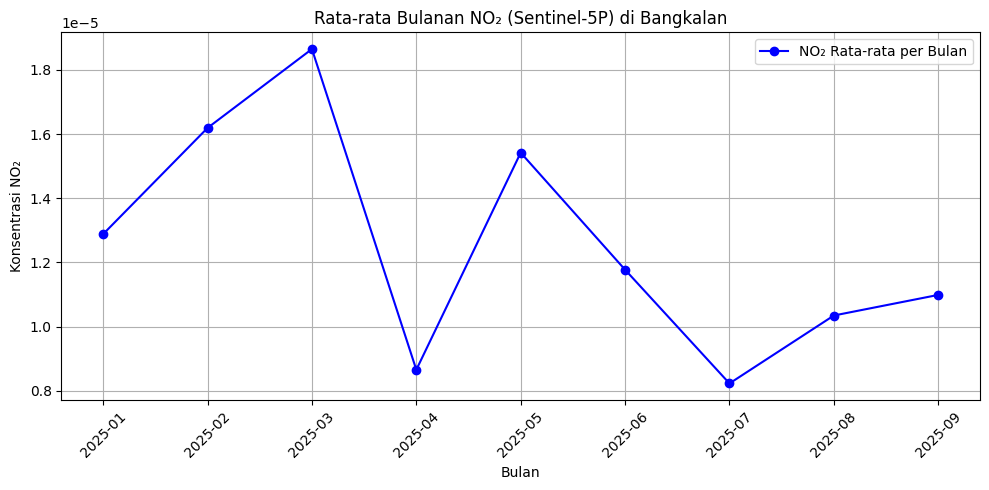

In [ ]:
# Baca data
df = pd.read_csv("no2_results/no2_banyuwangi_data.csv")

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13. Visualisasi hasil
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO₂ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO₂ (Sentinel-5P) di Bangkalan")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()